# Data Driven Modeling 1

## Data processing, loss function and the problem of overfitting

In [8]:
#%% Import necessary packages

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn import linear_model 
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_validate, LeaveOneOut, train_test_split

# set matplotlib parameters for plotting
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['axes.linewidth'] = 1.5
matplotlib.rcParams['xtick.major.size'] = 8
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['ytick.major.size'] = 8
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['figure.dpi'] = 100.


### 1. Inspect the dataset



(20640, 8)
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


Text(0,0.5,'Latitude')

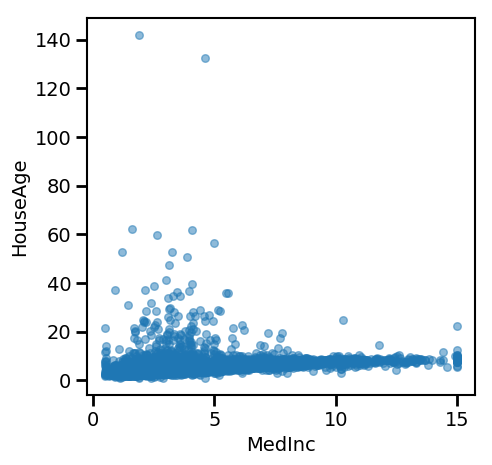

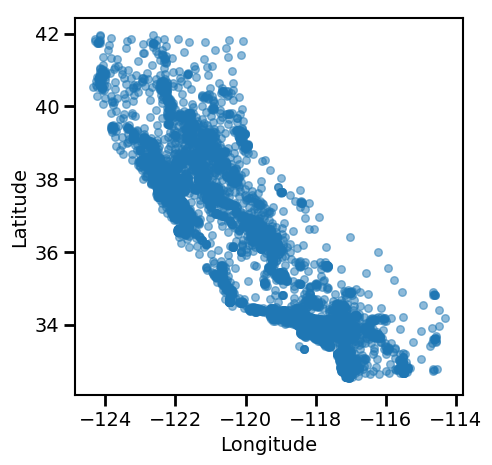

In [9]:
# fetch the housing dataset
dataset = fetch_california_housing()

# extract the features X and reponse y 
X_full, y_full = dataset.data, dataset.target
# check dataset sizes
print(X_full.shape)

# print out the feature names
X_names = dataset.feature_names
print(X_names)
y_name = 'Housing Price'
# Take only 2 features to make visualization easier
# Feature 0 and feature 1 have very different scales and distributions 
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(X_full[:,0], X_full[:,2], s = 30, alpha = 0.5)
ax.set_xlabel(X_names[0])
ax.set_ylabel(X_names[1])

# plot the last two features which gives the shape of the state of California! 
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(X_full[:,-1], X_full[:,-2], s = 30, alpha = 0.5)
ax.set_xlabel(X_names[-1])
ax.set_ylabel(X_names[-2])


### 2. Standardize the data to a unit variance and 0 mean

The std of each column in original X:
[1.89977569e+00 1.25852527e+01 2.47411320e+00 4.73899376e-01
 1.13243469e+03 1.03857980e+01 2.13590065e+00 2.00348319e+00]
The mean of each column in original X:
[1.89977569e+00 1.25852527e+01 2.47411320e+00 4.73899376e-01
 1.13243469e+03 1.03857980e+01 2.13590065e+00 2.00348319e+00]
The std of each column in standardized X:
[1. 1. 1. 1. 1. 1. 1. 1.]
The mean of each column standardized X:
[ 6.60969987e-17  5.50808322e-18  6.60969987e-17 -1.06030602e-16
 -1.10161664e-17  3.44255201e-18 -1.07958431e-15 -8.52651283e-15]


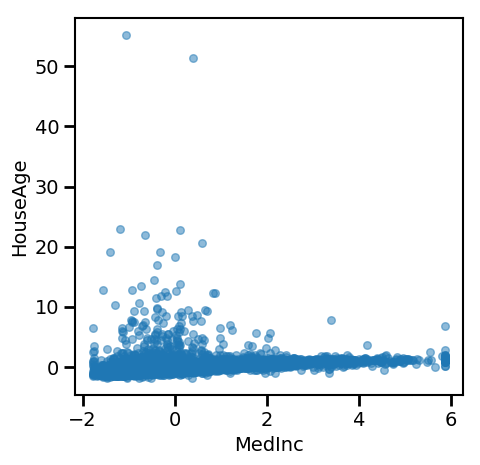

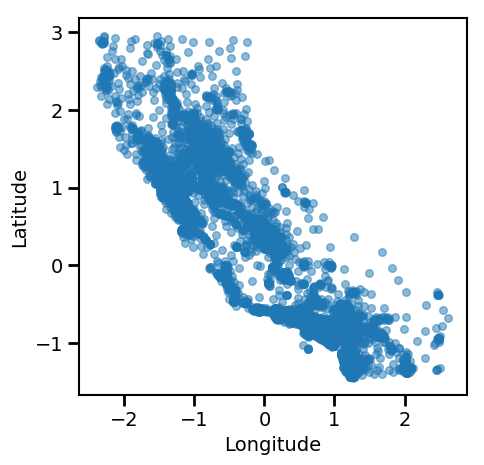

In [10]:
# Preprocess the data 
# Standardize 
scaler = StandardScaler().fit(X_full)
Xs = scaler.transform(X_full)

# Export the mean and std of the original data  
X_std = scaler.scale_ # std for each x variable
print('The std of each column in original X:')
print(X_std)

X_mean = scaler.mean_ # mean for each x variable
print('The mean of each column in original X:')
print(X_std)

# Check if there have a unit variance 
Xs_std = np.std(Xs, axis = 0) 
print('The std of each column in standardized X:')
print(Xs_std)

Xs_mean = np.mean(Xs, axis = 0)
print('The mean of each column standardized X:')
print(Xs_mean)


# Feature 0 and feature 1 after standardization
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(Xs[:,0], Xs[:,2], s = 30, alpha = 0.5)
ax.set_xlabel(X_names[0])
ax.set_ylabel(X_names[1])

# Last two features after standardization
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(Xs[:,-1], Xs[:,-2], s = 30, alpha = 0.5)
ax.set_xlabel(X_names[-1])
ax.set_ylabel(X_names[-2])

# Assign Xs to X
X = Xs.copy()
y = y_full.copy()


### 3. Split the data into training and test set, set up cross-validation

In [7]:
# 10 fold cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# check train and test set sizes
print(X_train.shape)
print(X_test.shape)

# Set up cross-validation scheme                                  
kfold = KFold(n_splits = 10, shuffle = True, random_state = 0)
loo = LeaveOneOut()

(16512, 8)
(4128, 8)


### 4. Create helper functions for linear regression

In [29]:
def prepare_poly_features(X, degree):
    """generate polynomial features

    :param X: original feature matrix
    :type X: np array
    :param degree: the degree of polynomial features
    :type degree: int
    :return: polynomial feature matrix
    :rtype: np array
    """
 
    
    X_poly = X.copy() # make a copy
    # 2D array is required, append a new axis if X is 1D
    if len(X_poly.shape) < 2:
        X_poly = X_poly[:, np.newaxis]
    poly = PolynomialFeatures(degree=degree, include_bias = False)
    X_poly = poly.fit_transform(X_poly)
    
    return X_poly

def linear_regression(X, y):
    """Create linear regression object

    :param X: feature matrix
    :type X: 2D np array
    :param y: response 
    :type y: 1D np array
    :return: regression model
    :rtype: sklearn object
    """   
    model = linear_model.LinearRegression(fit_intercept = True)
    model.fit(X, y)
    
    return model
    
def cross_validation(X, y, model, cv_method): 
    """Cross-validation

    :param X: feature matrix
    :type X: 2D np array
    :param y: response
    :type y: 1D np array
    :param model: regression model
    :type model: sklearn object
    :param cv_method: cross validation method
    :type cv_method: cv object
    :return: mean cv error  
    :rtype: float
    """    

    scores  = cross_validate(model, X, y, cv = cv_method,
                                scoring=('neg_mean_squared_error'),
                                return_train_score=True)
    
    # Use RMSE as the loss function (score)
    # Export train RMSE
    train_RMSE = np.sqrt(np.abs(scores['train_score']))  
    train_RMSE_mean = np.mean(train_RMSE)
    
    # Export cv RMSE (test set in cv is the validation set)
    cv_RMSE = np.sqrt(np.abs(scores['test_score']))  
    cv_RMSE_mean = np.mean(cv_RMSE)

    
    return train_RMSE_mean, cv_RMSE_mean 

### 5. Build linear regression models

Model 0 
- A single feature, degree = 1


Model 0 has 1 feature(s): 
 Test error of  0.85
 Training error of  0.83
 Validation error of  0.83


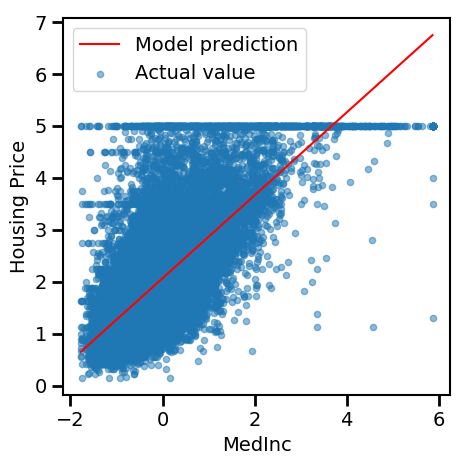

In [30]:
# generate polynomial features for both training and test set
X_poly_train_0 = prepare_poly_features(X_train[:, 0], degree =1)
X_poly_test_0 = prepare_poly_features(X_test[:,0], degree = 1)
n_features_0 = X_poly_train_0.shape[1]

# train the model using training set
model_0 = linear_regression(X_poly_train_0, y_train)
# cross validation
train_RMSE_0, cv_RMSE_0  = cross_validation(X_poly_train_0, 
                                                 y_train, 
                                                 model = model_0, 
                                                 cv_method = kfold)  
# make predict1ion for the test set and access the error
y_pred_0 = model_0.predict(X_poly_test_0)  
test_RMSE_0 = np.sqrt(mean_squared_error(y_test, y_pred_0))

# print out performance metrics
print('Model 0 has {0:} feature(s): '.format(n_features_0))      
print(' Test error of {0:5.2f}'.format(test_RMSE_0))
print(' Training error of {0:5.2f}'.format(train_RMSE_0))
print(' Validation error of {0:5.2f}'.format(cv_RMSE_0))


# Extract parameters from the model
intercept_0 = model_0.intercept_
coef_0 = model_0.coef_

# The prediction can also be calculated from the parameters
# Genral formula: y = intercept + np.dot(X, coef)
X0_min, X0_max = np.min(X[:,0]), np.max(X[:,0])
X_plot = np.linspace(X0_min, X0_max, 50)
y_plot = intercept_0 + X_plot * coef_0

# plot the actual data and prediction
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(X[:,0], y, s = 20, alpha = 0.5, label = 'Actual value')
ax.plot(X_plot, y_plot, color = 'r', label = 'Model prediction')
ax.set_xlabel(X_names[0])
ax.set_ylabel(y_name)
ax.legend()

#### Model 1
- A single feature, degree = 2

Model 1 has 2 feature(s): 
 Test error of  0.85
 Training error of  0.83
 Validation error of  0.83


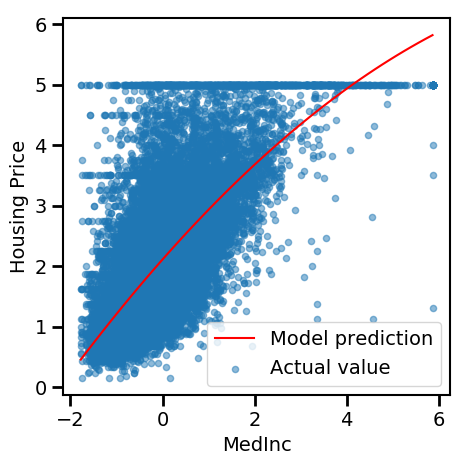

In [31]:
# generate polynomial features for both training and test set
X_poly_train_1 = prepare_poly_features(X_train[:, 0], degree =2)
X_poly_test_1 = prepare_poly_features(X_test[:,0], degree = 2)
# get the number of features
n_features_1 = X_poly_train_1.shape[1]

# train the model using training set
model_1 = linear_regression(X_poly_train_1, y_train)
# cross validation
train_RMSE_1, cv_RMSE_1  = cross_validation(X_poly_train_1, 
                                                 y_train, 
                                                 model = model_1, 
                                                 cv_method = kfold)  
# make predict1ion for the test set and access the error
y_pred_1 = model_1.predict(X_poly_test_1)  
test_RMSE_1 = np.sqrt(mean_squared_error(y_test, y_pred_1))

# print out performance metrics
print('Model 1 has {0:} feature(s): '.format(n_features_1))      
print(' Test error of {0:5.2f}'.format(test_RMSE_1))
print(' Training error of {0:5.2f}'.format(train_RMSE_1))
print(' Validation error of {0:5.2f}'.format(cv_RMSE_1))

# Extract parameters from the model
intercept_1 = model_1.intercept_
coef_1 = model_1.coef_

# The prediction can also be calculated from the parameters
# Genral formula: y = intercept + np.dot(X, coef)
X0_min, X0_max = np.min(X[:,0]), np.max(X[:,0])
X_plot = np.linspace(X0_min, X0_max, 50)
X_plot_poly = prepare_poly_features(X_plot, degree = 2)
y_plot = intercept_1 + np.dot(X_plot_poly, coef_1)

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(X[:,0], y, s = 20, alpha = 0.5, label = 'Actual value')
ax.plot(X_plot, y_plot, color = 'r', label = 'Model prediction')
ax.set_xlabel(X_names[0])
ax.set_ylabel(y_name)
ax.legend()



#### Model 2
- 8 features, polynomial degree= 1

In [32]:
# generate polynomial features for both training and test set
X_poly_train_2 = prepare_poly_features(X_train, degree =1)
X_poly_test_2 = prepare_poly_features(X_test, degree = 1)
# get the number of features
n_features_2 = X_poly_train_2.shape[1]
# train the model using training set
model_2 = linear_regression(X_poly_train_2, y_train)
# cross validation
train_RMSE_2, cv_RMSE_2  = cross_validation(X_poly_train_2, 
                                                 y_train, 
                                                 model = model_2, 
                                                 cv_method = kfold)  
# make prediction for the test set and access the error
y_pred_2 = model_2.predict(X_poly_test_2)  
test_RMSE_2 = np.sqrt(mean_squared_error(y_test, y_pred_2))

# print out performance metrics
print('Model 2 has {0:} feature(s): '.format(n_features_2))      
print(' Test error of {0:5.2f}'.format(test_RMSE_2))
print(' Training error of {0:5.2f}'.format(train_RMSE_2))
print(' Validation error of {0:5.2f}'.format(cv_RMSE_2))


Model 2 has 8 feature(s): 
 Test error of  0.73
 Training error of  0.72
 Validation error of  0.73


#### Model 3
- 8 features, polynomial degree= 2

In [33]:
# generate polynomial features for both training and test set
X_poly_train_3 = prepare_poly_features(X_train, degree =2)
X_poly_test_3 = prepare_poly_features(X_test, degree = 2)
# get the number of features
n_features_3 = X_poly_train_3.shape[1]
# train the model using training set
model_3 = linear_regression(X_poly_train_3, y_train)
# cross validation
train_RMSE_3, cv_RMSE_3  = cross_validation(X_poly_train_3, 
                                                 y_train, 
                                                 model = model_3, 
                                                 cv_method = kfold)  
# make prediction for the test set and access the error
y_pred_3 = model_3.predict(X_poly_test_3)  
test_RMSE_3 = np.sqrt(mean_squared_error(y_test, y_pred_3))

# print out performance metrics
print('Model 3 has {0:} feature(s): '.format(n_features_3))      
print(' Test error of {0:5.2f}'.format(test_RMSE_3))
print(' Training error of {0:5.2f}'.format(train_RMSE_3))
print(' Validation error of {0:5.2f}'.format(cv_RMSE_3))

Model 3 has 44 feature(s): 
 Test error of  1.66
 Training error of  0.65
 Validation error of  1.31


### 6. Plot the error versus the number of features (model complexity)




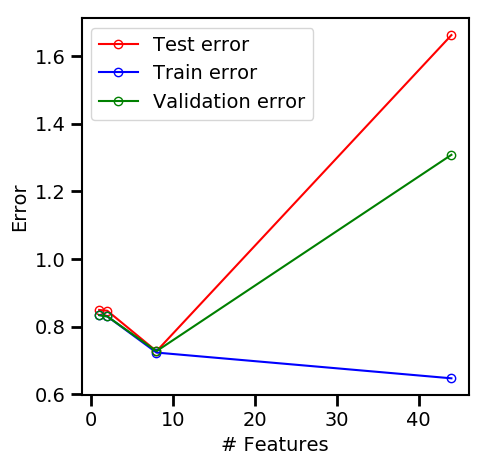

In [34]:
n_features = [n_features_0, n_features_1, n_features_2, n_features_3] 
test_RMSEs = [test_RMSE_0, test_RMSE_1, test_RMSE_2, test_RMSE_3] 
train_RMSEs = [train_RMSE_0, train_RMSE_1, train_RMSE_2, train_RMSE_3] 
cv_RMSEs = [cv_RMSE_0, cv_RMSE_1, cv_RMSE_2, cv_RMSE_3]

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(n_features, test_RMSEs, '-o', color = 'r', markerfacecolor = "None", label = 'Test error')
ax.plot(n_features, train_RMSEs, '-o',  color = 'b',  markerfacecolor = "None",label = 'Train error')
ax.plot(n_features, cv_RMSEs, '-o', color = 'g', markerfacecolor = "None", label = 'Validation error')
ax.set_xlabel('# Features')
ax.set_ylabel('Error')
ax.legend()
